In [1]:
# STEP 1: Install Required Libraries
!pip install requests beautifulsoup4 nltk wordcloud matplotlib pandas textblob scikit-learn imbalanced-learn joblib


In [2]:
# STEP 2: Import Libraries
import requests
from bs4 import BeautifulSoup
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np
from collections import Counter
import joblib
import os
import signal


In [3]:
# STEP 3: Download NLTK Resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# STEP 4: Scrape and Clean Wikipedia Text (Belgium)
url = "https://en.wikipedia.org/wiki/Belgium"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract and clean text
text = ' '.join([p.text for p in soup.find_all('p')])
text = re.sub(r'\[.*?\]', '', text)  # Remove [1], [2], ...
text = re.sub(r'[^a-zA-Z. ]', '', text)  # Remove non-alphabetic characters
text = text.lower()

print("Raw Text Sample:\n", text[:500])


Raw Text Sample:
  in europelight green dark greyin the european unionlight green belgium officially the kingdom of belgium is a country in northwestern europe. situated in a coastal lowland region known as the low countries it is bordered by the netherlands to the north germany to the east luxembourg to the southeast france to the south and the north sea to the west. belgium covers an area of km sqmi and has a population of more than . million its population density of km sqmi ranks nd in the world and sixth in 


In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Download the missing punkt_tab data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
# STEP 5: Sentence Tokenization
sentences = sent_tokenize(text)
print("Sample Sentences:", sentences[:5])


Sample Sentences: [' in europelight green dark greyin the european unionlight green belgium officially the kingdom of belgium is a country in northwestern europe.', 'situated in a coastal lowland region known as the low countries it is bordered by the netherlands to the north germany to the east luxembourg to the southeast france to the south and the north sea to the west.', 'belgium covers an area of km sqmi and has a population of more than .', 'million its population density of km sqmi ranks nd in the world and sixth in europe.', 'the capital and largest metropolitan region is brussels other major cities are antwerp ghent charleroi lige bruges namur and leuven.']


In [8]:
# STEP 6: Analyze Sentiment using TextBlob
def analyze_sentiment(sentence):
    polarity = TextBlob(sentence).sentiment.polarity
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

sentiments = [analyze_sentiment(s) for s in sentences]
df = pd.DataFrame({'sentence': sentences, 'sentiment': sentiments})
print(df.head())


                                            sentence sentiment
0   in europelight green dark greyin the european...  negative
1  situated in a coastal lowland region known as ...   neutral
2  belgium covers an area of km sqmi and has a po...  positive
3  million its population density of km sqmi rank...   neutral
4  the capital and largest metropolitan region is...  negative


In [9]:
# STEP 7 & 8: Word Tokenization and Remove Stopwords
words = word_tokenize(text)
stop_words = set(stopwords.words("english"))
filtered_words = [word for word in words if word not in stop_words and word.isalpha()]
print("Filtered Words Sample:", filtered_words[:20])


Filtered Words Sample: ['europelight', 'green', 'dark', 'greyin', 'european', 'unionlight', 'green', 'belgium', 'officially', 'kingdom', 'belgium', 'country', 'northwestern', 'europe', 'situated', 'coastal', 'lowland', 'region', 'known', 'low']


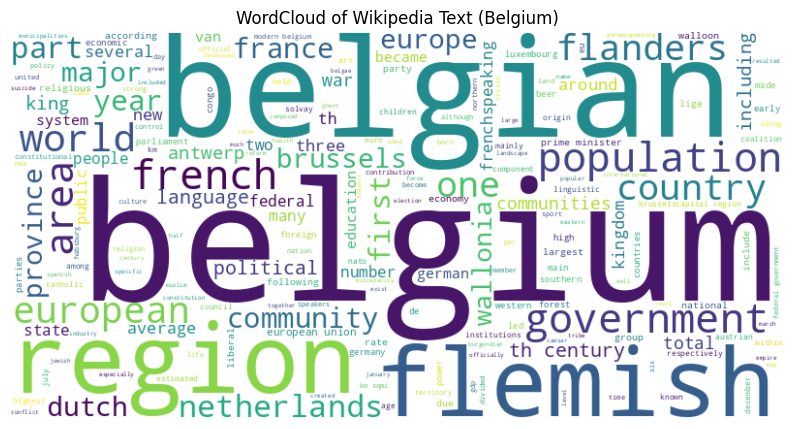

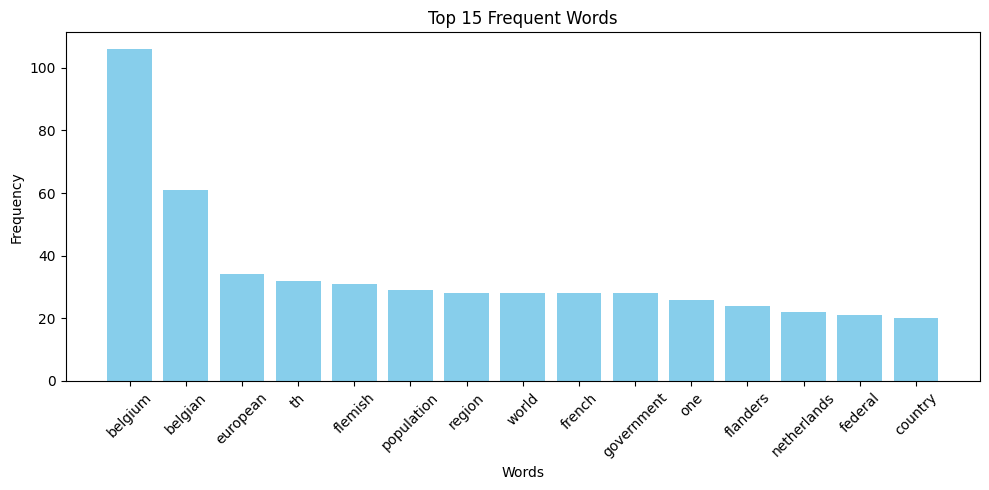

In [10]:
# WordCloud
all_words = ' '.join(filtered_words)
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Wikipedia Text (Belgium)")
plt.show()

# Frequency Plot
word_freq = Counter(filtered_words)
most_common_words = word_freq.most_common(15)
words, freqs = zip(*most_common_words)

plt.figure(figsize=(10, 5))
plt.bar(words, freqs, color='skyblue')
plt.title("Top 15 Frequent Words")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [11]:
# STEP 9: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['sentence'])
print("TF-IDF Matrix Shape:", X.shape)


TF-IDF Matrix Shape: (451, 2436)


In [12]:
# STEP 10: Binary Classification Setup + SMOTE
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df_binary = df.dropna(subset=['label'])
X_binary = X[df_binary.index]
y_binary = df_binary['label'].astype(int)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_binary, y_binary)

print("After SMOTE:", X_resampled.shape, y_resampled.shape)


After SMOTE: (386, 2436) (386,)


In [13]:
# Logistic Regression
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_resampled, y_resampled)
print("📊 Logistic Regression:\n", classification_report(y_resampled, logreg_model.predict(X_resampled)))

# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_resampled, y_resampled)
print("🌳 Decision Tree:\n", classification_report(y_resampled, dt_model.predict(X_resampled)))

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_resampled, y_resampled)
print("🌲 Random Forest:\n", classification_report(y_resampled, rf_model.predict(X_resampled)))

# Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_resampled, y_resampled)
print("🚀 Gradient Boosting:\n", classification_report(y_resampled, gb_model.predict(X_resampled)))

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_resampled, y_resampled)
print("🧠 Naive Bayes:\n", classification_report(y_resampled, nb_model.predict(X_resampled)))

# K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_resampled.toarray(), y_resampled)
print("👥 K-Nearest Neighbors:\n", classification_report(y_resampled, knn_model.predict(X_resampled.toarray())))


📊 Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       193
           1       0.98      1.00      0.99       193

    accuracy                           0.99       386
   macro avg       0.99      0.99      0.99       386
weighted avg       0.99      0.99      0.99       386

🌳 Decision Tree:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       193
           1       1.00      1.00      1.00       193

    accuracy                           1.00       386
   macro avg       1.00      1.00      1.00       386
weighted avg       1.00      1.00      1.00       386

🌲 Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       193
           1       1.00      1.00      1.00       193

    accuracy                           1.00       386
   macro avg       1.00      1.00      1.00       386
weighted avg  

In [14]:
# Save model and vectorizer
joblib.dump(rf_model, 'random_forest_sentiment_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [15]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
# Kill previous ngrok (if any)
for line in os.popen("ps ax | grep ngrok | grep -v grep"):
    fields = line.split()
    pid = fields[0]
    os.kill(int(pid), signal.SIGKILL)

# Install Streamlit & expose via localtunnel
!pip install streamlit -q
!wget -q -O - ipv4.icanhazip.com
! streamlit run app.py & npx localtunnel --port 8501


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.6 MB/s eta 0:00:00
146.148.72.112


⠙⠹⠸⠼⠴
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://146.148.72.112:8501

⠦Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹your url is: https://fifty-signs-tie.loca.lt
  Stopping...
^C
